In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [9]:
# Let's start by searching for a beer photo and seeing what kind of result we get. We'll start by getting URLs from a search:
urls = search_images('beer', max_images=1)
urls[0]

Searching for 'beer'


'https://api.time.com/wp-content/uploads/2015/05/beer1.jpg'

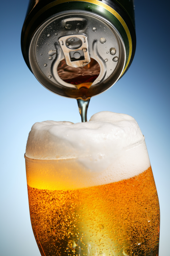

In [5]:
# Show a beer image
from fastdownload import download_url
dest = 'beer.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'bear'


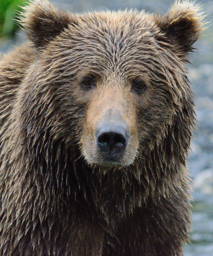

In [8]:
# Now let's do the same with "bear" photo:
download_url(search_images('bear', max_images=1)[0], 'bear.jpg', show_progress=False)
Image.open('bear.jpg').to_thumb(256,256)

In [10]:
# Our searches seem to be giving reasonable results, so let's grab a few examples of each of "beer" and "bear" photos, and save 
# each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):
searches = 'beer','bear'
path = Path('beer_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'brown {o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'white {o} photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o) # Make photos big enough for a fast processing

Searching for 'beer photo'
Searching for 'brown beer photo'
Searching for 'white beer photo'


/home/creem/mambaforge/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'bear photo'
Searching for 'brown bear photo'
Searching for 'white bear photo'


In [11]:
# Some photos might not download correctly which could cause our model training to fail, so we'll remove them:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

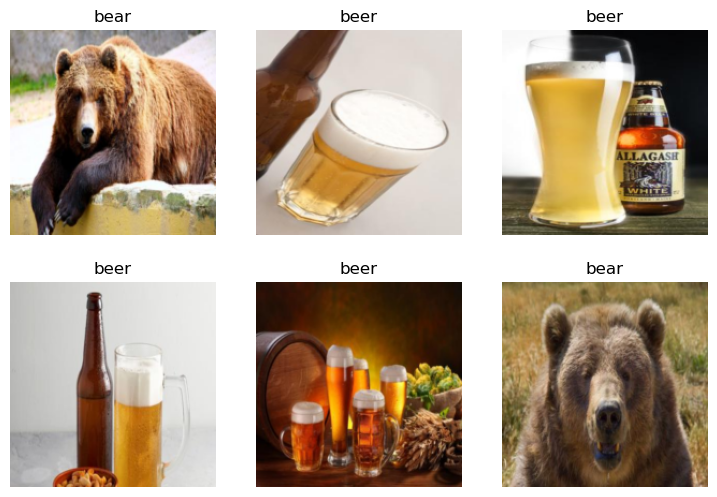

In [12]:
# To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) 
# and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create 
# that easily using a DataBlock, and view sample images from it:
dls = DataBlock(  # The model
    blocks=(ImageBlock, CategoryBlock), # The inputs to our model are images, and the outputs are categories.
    get_items=get_image_files, # The function to find all the inputs (which returns a list of all image files in a path).
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Split the data into training and validation sets randomly (80%/20%).
    get_y=parent_label, # The labels (y values) is the name of the parent (folder) of each file.
    item_tfms=[Resize(192, method='squish')] # Before training, resize each image to 192x192 pixels by "squishing" (as opposed to cropping it).
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate) # learner = pretratined model + current data
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.209836,0.027388,0.000000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.014329,0.002265,0.000000,00:03
1,0.007305,0.000093,0.000000,00:03
2,0.005120,0.000048,0.000000,00:02


In [15]:
# Check it on the beer image
is_beer,_,probs = learn.predict(PILImage.create('beer.jpg'))
print(f"This is a: {is_beer}.")
print(f"Probability it's a bear: {probs[0]:.4f}")

This is a: beer.
Probability it's a bear: 0.0000


In [16]:
# Check it with the bear photo
is_beer,_,probs = learn.predict(PILImage.create('bear.jpg'))
print(f"This is a: {is_beer}.")
print(f"Probability it's a bear: {probs[0]:.4f}")

This is a: bear.
Probability it's a bear: 1.0000
